In [3]:
library(knitr)
library(rmdformats)
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(formattable)
library(IRdisplay) # displays tables when in ipynb format

library(xgboost)
library(tidymodels)
#library(SHAPforxgboost)


source("./Baudry_functions_v2.R")

In [4]:
dt_PhoneData <- simulate_central_scenario(1234)


In [5]:


dt_polclaim <- join_policy_claim(dt_PhoneData,
                                 date_pol_start = "date_UW",
                                 date_pol_end = "date_lapse",
                                 date_occur = "date_occur")


In [6]:

lst_Date_slice <- floor_date(seq(as.Date("2016/1/1"), as.Date("2019/06/30"), by = 30), unit= "second") 
dt_polclaim <- time_slice_polclaim(dt_polclaim, lst_Date_slice)

In [7]:


i <- valuation <- 10
t_i <- lst_Date_slice[i] 
delta <- min(i, length(lst_Date_slice) - i + 1)


In [8]:
#define modelVars
RBNS_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     "target"
    )


# Create a combined TRAIN dataset for k = 1 and all valid j delay values
dt_RBNS_train <- RBNS_Train(dt_polclaim, t_i, i, k = 1, lst_Date_slice, RBNS_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_RBNS_test <- RBNS_Test(dt_polclaim, t_i, delta, k = 1, lst_Date_slice, RBNS_model_vars)

In [9]:


# Add a flag to determine which rows are from the trainset and which from the test set
dt_RBNS_train[, flgTrain := 1]
dt_RBNS_test[, flgTrain := 0]

# combine into a single RBNS dataset   
dt_All_RBNS <- rbind(dt_RBNS_train, dt_RBNS_test)
#write.csv(dt_All_RBNS,"dt_All_RBNS.csv", row.names = F)


In [10]:
# tidy up
rm(dt_RBNS_train)
rm(dt_RBNS_test)
gc()
    

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2920168,156.0,6451977,344.6,4606140,246.0
Vcells,40896117,312.1,67751861,517.0,56319961,429.7


In [11]:
# order and create some delay fields
setkey(dt_All_RBNS, clm_number, k, j)
    
dt_All_RBNS[, Count := .N , by =clm_number]

#create delay measures and convert time measures from intervals of seconds to intervals of days
dt_All_RBNS[, ':='(
  delay_uw_occ = ifelse(year(date_occur) == 2199,
                        -1,
                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start)) / (24 * 60 * 60))
                        ),
  delay_occ_rep = ifelse(year(date_occur) == 2199,
                         -1,
                         ceiling((as.numeric(date_report) - as.numeric(date_occur)) / (24 * 60 * 60))
                         ),
  delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start)) / (24 * 60 * 60)),
  delay_rep_pay = ceiling((as.numeric(date_pay) - as.numeric(date_report)) / (24 * 60 * 60)),
  
  date_uw = ceiling(as.numeric(date_pol_start) / (24 *  60 * 60)),
  Cover = as.factor(Cover),
  claim_type = as.factor(claim_type)
  )]
  

In [12]:
#define IBNR modelVars
IBNR_model_vars <- c("clm_number",
                     "pol_number",
                     "j",
                     "k",
                     "exposure",
                     "date_pol_start",
                     "date_occur",
                     "date_report",
                     "date_pay",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "target")
    
# Create a combined TRAIN dataset for k = 1 and all valid j delay values
lst_IBNR_train <- IBNR_Train(dt_polclaim, t_i, i, k = 1,lst_Date_slice, IBNR_model_vars)

# Create a combined TEST dataset for k = 1 and all valid j delay values
dt_IBNR_test <- IBNR_Test(dt_polclaim, t_i, delta, k = 1,lst_Date_slice, IBNR_model_vars)

     

In [14]:

lst_IBNR_train$Freq[, flgTrain := 1]
lst_IBNR_train$Loss[, flgTrain := 2]
dt_IBNR_test[, flgTrain := 0]

dt_All_IBNR <- rbind(
  lst_IBNR_train$Freq,
  lst_IBNR_train$Loss,
  dt_IBNR_test
)

#write.csv(dt_All_IBNR,"dt_All_IBNR.csv", row.names = F)

In [15]:
# tidy up
rm(lst_IBNR_train)
rm(dt_IBNR_test)
gc()



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2926375,156.3,6451977,344.6,4606140,246.0
Vcells,75735065,577.9,140919696,1075.2,140546525,1072.3


In [16]:
# order and create some delay fields
setkey(dt_All_IBNR, clm_number, k, j)
    
dt_All_IBNR[, Count := .N , by =clm_number]
dt_All_IBNR[,':='( delay_uw_occ = ifelse(year(date_occur) == 2199,
                                        -1,
                                        ceiling((as.numeric(date_occur) - as.numeric(date_pol_start))
                                                  /(24*60*60))
                                          ),
                   delay_occ_rep = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_report) - as.numeric(date_occur))
                                                  /(24*60*60))
                                          ),
                   delay_rep_pay = ifelse(year(date_occur) == 2199,
                                          -1,
                                          ceiling((as.numeric(date_pay) - as.numeric(date_report))
                                                  /(24*60*60))
                                          ),
                   delay_uw_val = ceiling((as.numeric(t_i) - as.numeric(date_pol_start))/(24*60*60)),
                   date_uw = ceiling(as.numeric(date_pol_start)/(24*60*60)),
                   Cover = as.factor(Cover))]

In [18]:
RBNS_predictors <- c("j",
                     "k",
                     "Cover",
                     "claim_type",
                     "Brand",
                     "Model",
                     "Price",
                     #"date_uw",
                     #"delay_uw_occ",
                     "delay_occ_rep")

rowList_RBNS <- list(train=dt_All_RBNS[, which(flgTrain==1)],
                test=dt_All_RBNS[, which(flgTrain==0)],
                all = 1:nrow(dt_All_RBNS))


RBNS_rec <- recipe( ~ ., data = dt_All_RBNS[, RBNS_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()


df.RBNS_train <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$train,] )
df.RBNS_test <- bake(RBNS_rec, new_data = dt_All_RBNS[rowList_RBNS$test,] )
df.RBNS_all <- bake(RBNS_rec, new_data = dt_All_RBNS )


xgb.RBNS_DMat.train <- xgb.DMatrix(data = as.matrix(df.RBNS_train),
                              label = dt_All_RBNS[rowList_RBNS$train, target])

xgb.RBNS_DMat.test <- xgb.DMatrix(data = as.matrix(df.RBNS_test),
                              label = dt_All_RBNS[rowList_RBNS$test, target])

xgb.RBNS_DMat.all <- xgb.DMatrix(data = as.matrix(df.RBNS_all),
                             label = dt_All_RBNS[, target])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   76.44    0.00  913.00 

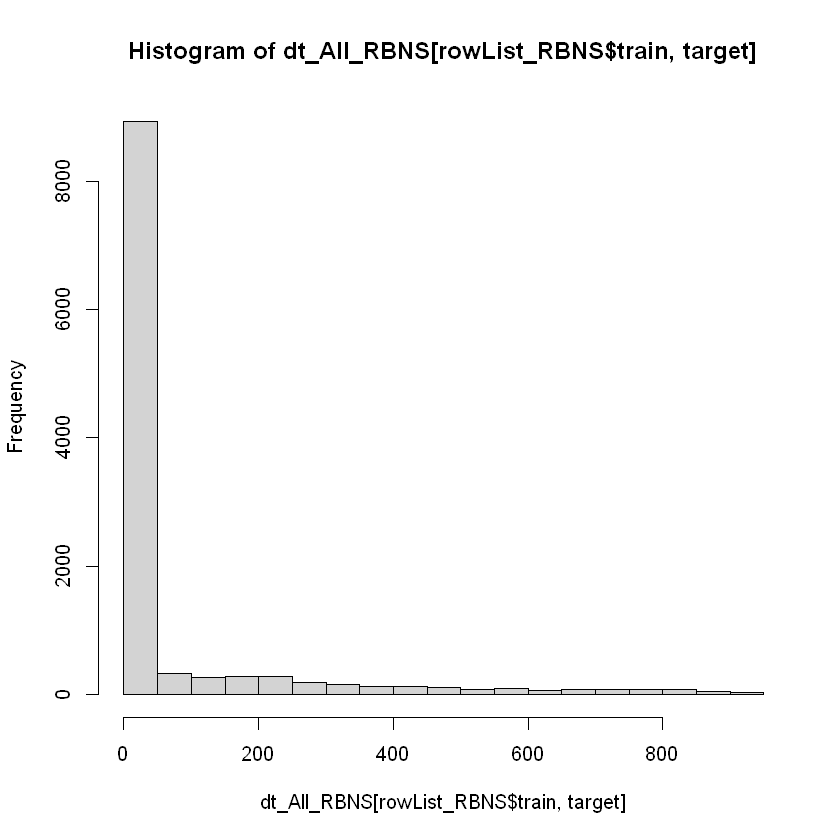

In [19]:
summary(dt_All_RBNS[rowList_RBNS$train, target])
hist(dt_All_RBNS[rowList_RBNS$train, target])

In [20]:
param <- list(
  objective = "reg:tweedie",
  max_depth = 2L,            # tree-depth
  subsample = 0.75,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,    # randomly sample columns before fitting each tree
  min.child.weight = 10,     # minimum weight per leaf
  eta = 0.1                  # Learning rate
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_RBNS_CV <- xgb.cv(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = 500,        # Maximum number of trees to build
  nfold = 5,
  early_stopping_rounds  = 10L,        # Stops algorithm early if performance has not improved in 
  print_every_n          = 10L,        # How often to print to console
  prediction             = TRUE        # Keeps the predictions
)

[1]	train-tweedie-nloglik@1.5:58.009016+0.518944	test-tweedie-nloglik@1.5:58.010415+1.320197 
Multiple eval metrics are present. Will use test_tweedie_nloglik@1.5 for early stopping.
Will train until test_tweedie_nloglik@1.5 hasn't improved in 10 rounds.

[11]	train-tweedie-nloglik@1.5:30.450703+0.768483	test-tweedie-nloglik@1.5:30.453809+0.690378 
[21]	train-tweedie-nloglik@1.5:22.203900+0.201559	test-tweedie-nloglik@1.5:22.239458+0.302289 
[31]	train-tweedie-nloglik@1.5:20.335487+0.097273	test-tweedie-nloglik@1.5:20.358262+0.348085 
[41]	train-tweedie-nloglik@1.5:19.797811+0.060289	test-tweedie-nloglik@1.5:19.824879+0.331764 
[51]	train-tweedie-nloglik@1.5:19.590436+0.067170	test-tweedie-nloglik@1.5:19.620479+0.304170 
[61]	train-tweedie-nloglik@1.5:19.496678+0.066665	test-tweedie-nloglik@1.5:19.530647+0.298147 
[71]	train-tweedie-nloglik@1.5:19.452399+0.067554	test-tweedie-nloglik@1.5:19.493740+0.296797 
[81]	train-tweedie-nloglik@1.5:19.427254+0.070937	test-tweedie-nloglik@1.5:19.4

In [21]:
dt_All_RBNS[rowList_RBNS$train, preds_oof := xgb_RBNS_CV$pred]

In [22]:
xgb_RBNS_Fit <- xgb.train(
  params                 = param,
  data                   = xgb.RBNS_DMat.train,
  nrounds                = xgb_RBNS_CV$best_iteration,
# base_score             = 1,
  watchlist              = list(train=xgb.RBNS_DMat.train, test=xgb.RBNS_DMat.test) ,
  print_every_n          = 10
)

dt_All_RBNS[, preds_full := predict(xgb_RBNS_Fit,xgb.RBNS_DMat.all)]



[1]	train-tweedie-nloglik@1.5:57.808928	test-tweedie-nloglik@1.5:26.862921 
[11]	train-tweedie-nloglik@1.5:30.558274	test-tweedie-nloglik@1.5:14.785928 
[21]	train-tweedie-nloglik@1.5:22.444941	test-tweedie-nloglik@1.5:10.570288 
[31]	train-tweedie-nloglik@1.5:20.495140	test-tweedie-nloglik@1.5:9.257596 
[41]	train-tweedie-nloglik@1.5:19.871867	test-tweedie-nloglik@1.5:8.692482 
[51]	train-tweedie-nloglik@1.5:19.625733	test-tweedie-nloglik@1.5:8.448683 
[61]	train-tweedie-nloglik@1.5:19.529502	test-tweedie-nloglik@1.5:8.356433 
[71]	train-tweedie-nloglik@1.5:19.479592	test-tweedie-nloglik@1.5:8.303847 
[81]	train-tweedie-nloglik@1.5:19.440620	test-tweedie-nloglik@1.5:8.274222 
[91]	train-tweedie-nloglik@1.5:19.426660	test-tweedie-nloglik@1.5:8.261640 
[95]	train-tweedie-nloglik@1.5:19.422917	test-tweedie-nloglik@1.5:8.257654 


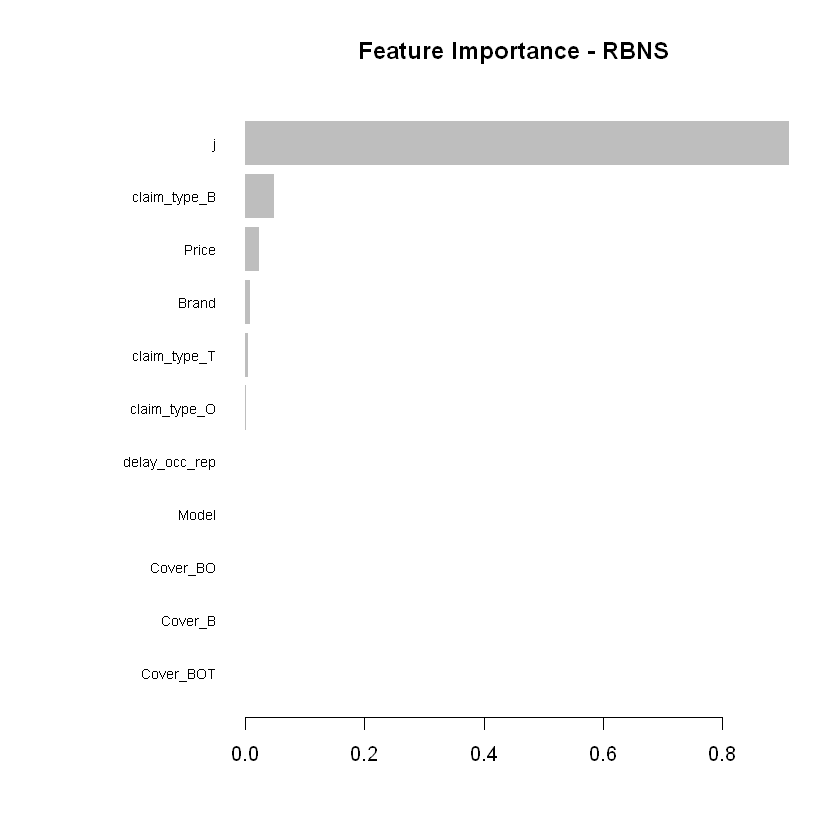

In [23]:
#default feature importance by gain
featImp_RBNS <- xgb.importance(xgb_RBNS_Fit, feature_names = colnames(xgb.RBNS_DMat.train))
xgb.plot.importance(featImp_RBNS, main="Feature Importance - RBNS")

In [24]:
# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_RBNS_Fit, X_train = as.matrix(df.RBNS_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.RBNS_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = nrow(df.RBNS_train)/10000)

ERROR: Error in shap.values(xgb_model = xgb_RBNS_Fit, X_train = as.matrix(df.RBNS_train)): could not find function "shap.values"


In [25]:

fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)

ERROR: Error in match.fun(FUN): object 'shap.plot.dependence' not found


In [26]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/nrow(shap_long),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  

ERROR: Error in shap.prep.stack.data(shap_contrib = shap_values$shap_score, data_percent = 10000/nrow(shap_long), : could not find function "shap.prep.stack.data"


In [27]:
dt_All_RBNS [, date_occur_YYYYMM := as.character(year(date_occur) + month(date_occur)/100 )]

dt_RBNS_summary <- dt_All_RBNS[rowList_RBNS$test,.(preds = sum(preds_full), target = sum(target)), keyby = date_occur_YYYYMM]


     

In [28]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_occur_YYYYMM = "Total"), dt_RBNS_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_RBNS_summary <- rbind(dt_RBNS_summary, sumrow, fill = TRUE)

dt_RBNS_summary[, ':='(Diff = (preds - target),
                       Diff_pcnt =  scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_RBNS_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_occur_YYYYMM,preds,target,Diff,Diff_pcnt
2016.04,"1,066",911,155,17.1%
2016.05,"5,147","5,188",-41,-0.8%
2016.06,"12,275","14,257","-1,982",-13.9%
2016.07,"56,097","53,815","2,282",4.2%
2016.08,"326,004","326,631",-627,-0.2%
2016.09,"618,081","622,179","-4,098",-0.7%
Total,"1,018,670","1,022,981","-4,311",-0.4%


In [29]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

# aggregate the data ... does this lead to loss of variance and accuracy?
dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_F <- dt_All_IBNR[, .(exposure = sum(exposure),
                                   target_cost = sum(target),
                                   target_count = sum(target>0)),
                               by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_F <- dt_All_IBNR_F[exposure>0]


# setup train and test rows
rowList_IBNR_F <- list(train=dt_All_IBNR_F[, which(flgTrain==1)],
                     test=dt_All_IBNR_F[, which(flgTrain==0)],
                     all = dt_All_IBNR_F[, which(flgTrain!=2)])

# setup data for xgboost
IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_F[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_F_train <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$train,] )
df.IBNR_F_test <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$test,] )
df.IBNR_F_all <- bake(IBNR_rec, new_data = dt_All_IBNR_F[rowList_IBNR_F$all,] )

xgb.IBNR_F_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_F_train),
                              weight = dt_All_IBNR_F[rowList_IBNR_F$train, exposure],
                              label = dt_All_IBNR_F[rowList_IBNR_F$train, target_count])

xgb.IBNR_F_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_F_test),
                             weight = dt_All_IBNR_F[rowList_IBNR_F$test, exposure],
                             label = dt_All_IBNR_F[rowList_IBNR_F$test, target_count])

xgb.IBNR_F_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_F_all),
                            weight = dt_All_IBNR_F[rowList_IBNR_F$all, exposure],
                            label = dt_All_IBNR_F[rowList_IBNR_F$all, target_count])

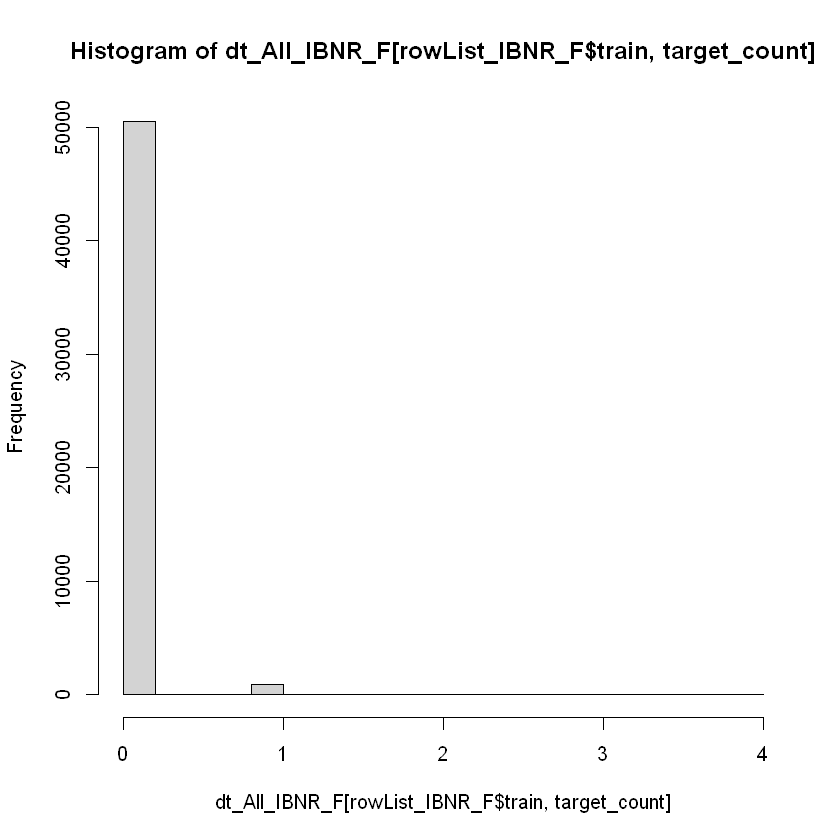

In [30]:

hist(dt_All_IBNR_F[rowList_IBNR_F$train, target_count])

In [31]:
param <- list(
  objective = "count:poisson",
  max_depth = 2L,           # tree-depth
  subsample = 0.7,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree
  min.child.weight = 10,    # minimum weight per leaf
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)


# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_F_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_F_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
)


[1]	train-poisson-nloglik:0.615983+0.000516	test-poisson-nloglik:0.615994+0.001036 
Multiple eval metrics are present. Will use test_poisson_nloglik for early stopping.
Will train until test_poisson_nloglik hasn't improved in 50 rounds.

[51]	train-poisson-nloglik:0.169375+0.002012	test-poisson-nloglik:0.169430+0.005815 
[101]	train-poisson-nloglik:0.137262+0.002201	test-poisson-nloglik:0.137737+0.007821 
[151]	train-poisson-nloglik:0.132682+0.002179	test-poisson-nloglik:0.134066+0.008458 
[201]	train-poisson-nloglik:0.130792+0.002139	test-poisson-nloglik:0.133186+0.008710 
[251]	train-poisson-nloglik:0.129587+0.002116	test-poisson-nloglik:0.132927+0.008899 
[301]	train-poisson-nloglik:0.128581+0.002063	test-poisson-nloglik:0.133057+0.008991 
Stopping. Best iteration:
[267]	train-poisson-nloglik:0.129243+0.002140	test-poisson-nloglik:0.132899+0.008906



In [32]:
 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_F := xgb_IBNR_F_CV$pred]
 dt_All_IBNR_F[rowList_IBNR_F$train, preds_oof_IBNR_Nos := exposure * preds_oof_IBNR_F]

In [41]:
xgb_IBNR_F_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_F_DMat.train,
   nrounds                = xgb_IBNR_F_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )
 
 dt_All_IBNR_F[rowList_IBNR_F$all, preds_full_IBNR_Nos := predict(xgb_IBNR_F_Fit,xgb.IBNR_F_DMat.all)]

     

[1]	train-poisson-nloglik:0.616065	test-poisson-nloglik:0.606831 
[51]	train-poisson-nloglik:0.169623	test-poisson-nloglik:0.129184 
[101]	train-poisson-nloglik:0.137296	test-poisson-nloglik:0.088775 
[151]	train-poisson-nloglik:0.132780	test-poisson-nloglik:0.084293 
[201]	train-poisson-nloglik:0.131201	test-poisson-nloglik:0.083150 
[251]	train-poisson-nloglik:0.130244	test-poisson-nloglik:0.083090 
[267]	train-poisson-nloglik:0.129909	test-poisson-nloglik:0.083045 


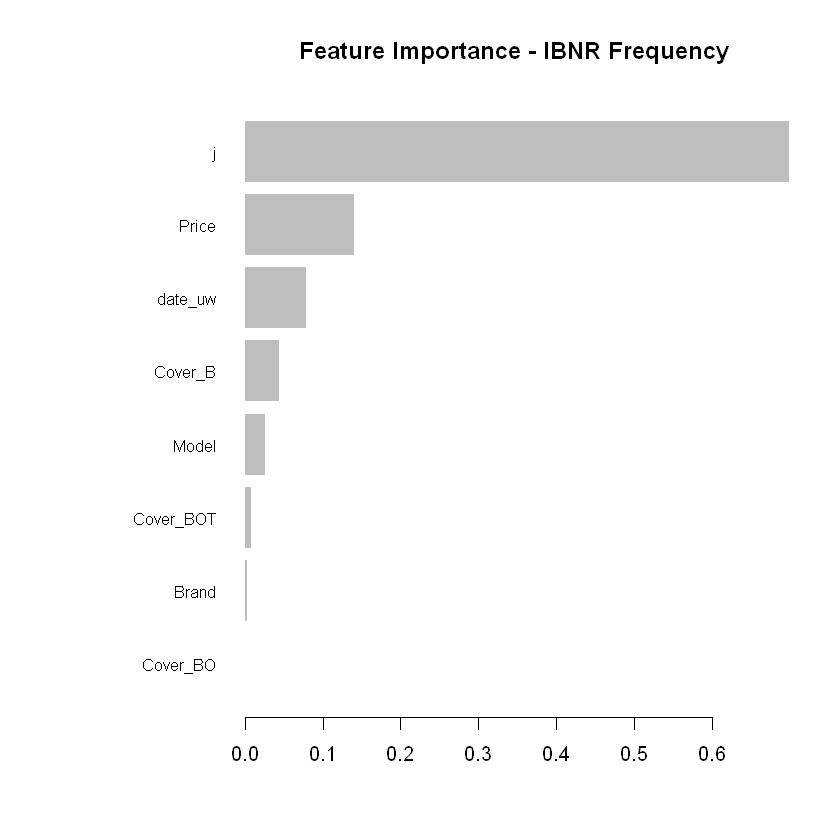

In [42]:
featImp_IBNR_F <- xgb.importance(xgb_IBNR_F_Fit, feature_names = colnames(xgb.IBNR_F_DMat.train))
xgb.plot.importance(featImp_IBNR_F, main="Feature Importance - IBNR Frequency")


In [43]:



# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_IBNR_F_Fit, X_train = as.matrix(df.IBNR_F_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.IBNR_F_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = nrow(df.IBNR_F_train)/10000)



ERROR: Error in shap.values(xgb_model = xgb_IBNR_F_Fit, X_train = as.matrix(df.IBNR_F_train)): could not find function "shap.values"


In [44]:



fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)


ERROR: Error in match.fun(FUN): object 'shap.plot.dependence' not found


In [45]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/nrow(shap_long),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))
  

ERROR: Error in shap.prep.stack.data(shap_contrib = shap_values$shap_score, data_percent = 10000/nrow(shap_long), : could not find function "shap.prep.stack.data"


In [46]:
dt_All_IBNR_F_summary <- dt_All_IBNR_F[rowList_IBNR_F$test,.(preds = sum(preds_full_IBNR_Nos), target = sum(target_count)), keyby = date_pol_start_YYYYMM]

In [47]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_F_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_F_summary <- rbind(dt_All_IBNR_F_summary, sumrow, fill = TRUE)

dt_All_IBNR_F_summary[, ':='(Diff = (preds - target),
                        Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_F_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,212,168,44,25.9%
2016.02,186,176,10,5.8%
2016.03,188,160,28,17.2%
2016.04,184,164,20,12.1%
2016.05,177,195,-18,-9.2%
2016.06,167,179,-12,-6.9%
2016.07,113,170,-57,-33.3%
2016.08,85,162,-77,-47.4%
2016.09,77,59,18,30.0%
Total,"1,388","1,433",-45,-3.1%


In [49]:
IBNR_predictors <- c("j",
                     "k",
                     "Cover",
                     "Brand",
                     "Model",
                     "Price",
                     "date_uw")

dt_All_IBNR [, date_pol_start_YYYYMM := as.character(year(date_pol_start) + month(date_pol_start)/100 )]

dt_All_IBNR_S <- dt_All_IBNR[, .(exposure = sum(target>0),
                                 target_cost = sum(target)),
                            by= c(IBNR_predictors, "date_pol_start_YYYYMM", "flgTrain")]

dt_All_IBNR_S <- dt_All_IBNR_S[exposure>0]

# setup train and test rows
rowList_IBNR_S <- list(train=dt_All_IBNR_S[, which(flgTrain==2)],
                     test=dt_All_IBNR_S[, which(flgTrain==0)],
                     all = dt_All_IBNR_S[, which(flgTrain!=1)])

# setup data for xgboost

IBNR_rec <- recipe( ~ ., data = dt_All_IBNR_S[, IBNR_predictors, with = FALSE]) %>%
  step_dummy(all_nominal(), one_hot = TRUE) %>%
  prep()

df.IBNR_S_train <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$train,] )
df.IBNR_S_test <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$test,] )
df.IBNR_S_all <- bake(IBNR_rec, new_data = dt_All_IBNR_S[rowList_IBNR_S$all,] )



xgb.IBNR_S_DMat.train <- xgb.DMatrix(data = as.matrix(df.IBNR_S_train),
                              weight = dt_All_IBNR_S[rowList_IBNR_S$train, exposure],
                              label = dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

xgb.IBNR_S_DMat.test <- xgb.DMatrix(data = as.matrix(df.IBNR_S_test),
                             weight = dt_All_IBNR_S[rowList_IBNR_S$test, exposure],
                             label = dt_All_IBNR_S[rowList_IBNR_S$test, target_cost])

xgb.IBNR_S_DMat.all <- xgb.DMatrix(data = as.matrix(df.IBNR_S_all),
                            weight = dt_All_IBNR_S[rowList_IBNR_S$all, exposure],
                            label = dt_All_IBNR_S[rowList_IBNR_S$all, target_cost])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0   125.5   255.0   353.9   486.5  2011.0 

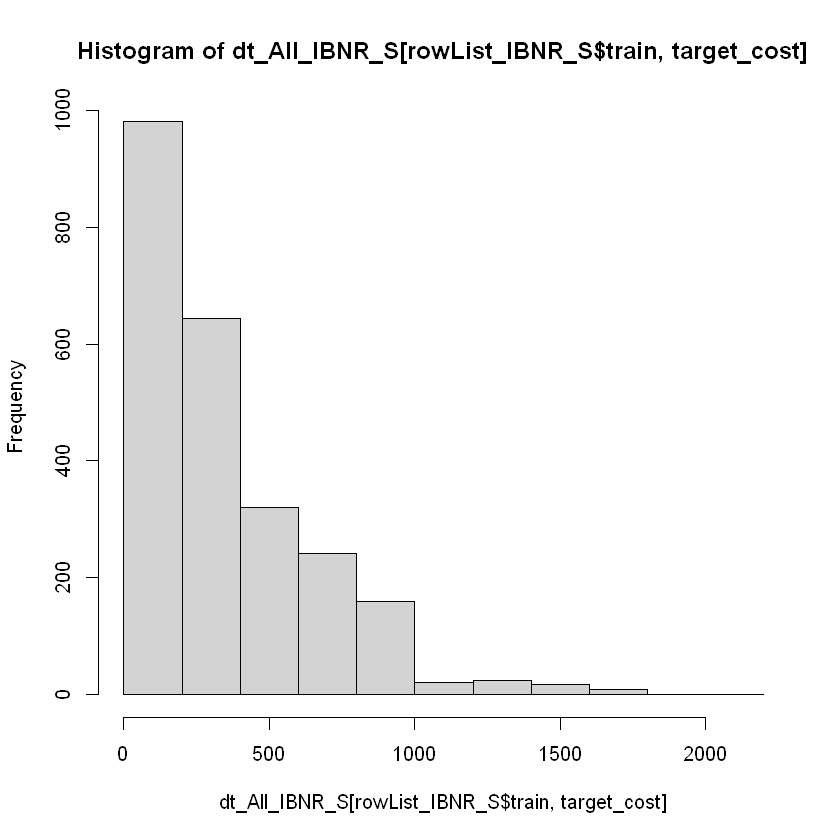

In [50]:
summary(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])
hist(dt_All_IBNR_S[rowList_IBNR_S$train, target_cost])

In [51]:
param <- list(
  objective = "reg:gamma",
  max_depth = 2L,           # tree-depth
  subsample = 0.7,          # randomly sample rows before fitting each tree
  colsample_bytree = 0.8,   # randomly sample columns before fitting each tree
  min.child.weight = 10,    # minimum weight per leaf
  eta = 0.1               # Learning rate
  #monotone_constraints = monotone_Vec # Monotonicity constraints
)

# Train model with cross validation
set.seed(1984) # for repeatability

xgb_IBNR_S_CV <- xgb.cv(
 params                 = param,
 data                   = xgb.IBNR_S_DMat.train,
 nrounds                = 2000,        # Maximum number of trees to build
 nfold = 5,

 early_stopping_rounds  = 50L,        # Stops algorithm early if performance has not improved in n rounds
 print_every_n          = 50L,        # How often to print to console
 #base_score             = 0.001,       # Model starting point
   prediction             = TRUE        # Keeps the predictions
) 
     

[1]	train-gamma-nloglik:135.111800+2.147737	test-gamma-nloglik:134.960497+8.878000 
Multiple eval metrics are present. Will use test_gamma_nloglik for early stopping.
Will train until test_gamma_nloglik hasn't improved in 50 rounds.

[51]	train-gamma-nloglik:7.117216+0.023912	test-gamma-nloglik:7.122154+0.130271 
[101]	train-gamma-nloglik:6.815663+0.017024	test-gamma-nloglik:6.825915+0.070990 
[151]	train-gamma-nloglik:6.808179+0.017122	test-gamma-nloglik:6.826168+0.070992 
Stopping. Best iteration:
[121]	train-gamma-nloglik:6.811926+0.017127	test-gamma-nloglik:6.825021+0.070641



In [52]:
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_S := xgb_IBNR_S_CV$pred]
dt_All_IBNR_S[rowList_IBNR_S$train, preds_oof_IBNR_Cost := exposure * preds_oof_IBNR_S]

In [53]:

xgb_IBNR_S_Fit <- xgb.train(
   params                 = param,
   data                   = xgb.IBNR_S_DMat.train,
   nrounds                = xgb_IBNR_S_CV$best_iteration,
# base_score             = 1,
   watchlist              = list(train=xgb.IBNR_F_DMat.train, test=xgb.IBNR_F_DMat.test) ,
   print_every_n          = 50
 )

     

[1]	train-gamma-nloglik:1.110040	test-gamma-nloglik:1.105260 
[51]	train-gamma-nloglik:5.196263	test-gamma-nloglik:5.193286 
[101]	train-gamma-nloglik:5.663059	test-gamma-nloglik:5.647153 
[121]	train-gamma-nloglik:5.642347	test-gamma-nloglik:5.595071 


In [54]:
dt_All_IBNR_S[rowList_IBNR_S$all, preds_full_IBNR_Cost := predict(xgb_IBNR_S_Fit,xgb.IBNR_S_DMat.all)]
     

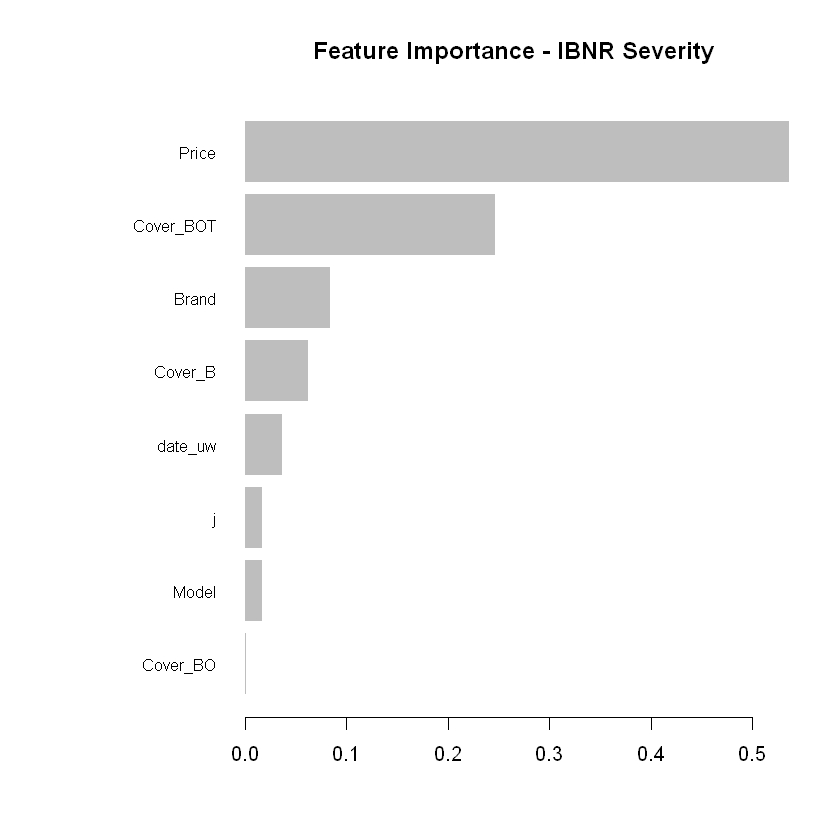

In [55]:


#default feature importance by gain
featImp_IBNR_S <- xgb.importance(xgb_IBNR_S_Fit, feature_names = colnames(xgb.IBNR_S_DMat.train))
xgb.plot.importance(featImp_IBNR_S, main="Feature Importance - IBNR Severity")

In [56]:
# Return the SHAP values and ranked features by mean|SHAP|
shap_values <- shap.values(xgb_model = xgb_IBNR_S_Fit, X_train = as.matrix(df.IBNR_S_train))

# Prepare the long-format data:
shap_long <- shap.prep(shap_contrib = shap_values$shap_score, X_train =  as.matrix(df.IBNR_S_train))

# **SHAP summary plot**
shap.plot.summary(shap_long, dilute = max(nrow(df.IBNR_S_train),10000)/10000)
     

ERROR: Error in shap.values(xgb_model = xgb_IBNR_S_Fit, X_train = as.matrix(df.IBNR_S_train)): could not find function "shap.values"


In [57]:

fig_list <- lapply(names(shap_values$mean_shap_score)[1:4], 
                   shap.plot.dependence,
                   data_long = shap_long,
                   dilute = nrow(shap_long)/ 10000)

gridExtra::grid.arrange(grobs = fig_list, ncol = 2)

ERROR: Error in match.fun(FUN): object 'shap.plot.dependence' not found


In [58]:
# choose to show top 4 features by setting `top_n = 4`, set 6 clustering groups.  
plot_data <- shap.prep.stack.data(shap_contrib = shap_values$shap_score,
                                  data_percent = 10000/max(nrow(shap_long),10000),
                                  top_n = 4,
                                  n_groups = 6)
  
# choose to zoom in at location 500, set y-axis limit using `y_parent_limit`  
# it is also possible to set y-axis limit for zoom-in part alone using `y_zoomin_limit`  
shap.plot.force_plot(plot_data, zoom_in_location = 500, y_parent_limit = c(-1,1))

ERROR: Error in shap.prep.stack.data(shap_contrib = shap_values$shap_score, data_percent = 10000/max(nrow(shap_long), : could not find function "shap.prep.stack.data"


In [59]:
dt_All_IBNR_S_summary <- dt_All_IBNR_S[rowList_IBNR_S$test,.(preds = sum(preds_full_IBNR_Cost), target = sum(target_cost)), keyby = date_pol_start_YYYYMM]
     

In [60]:
# Sum the last row of each column if numeric 
sumrow <- cbind(data.table(date_pol_start_YYYYMM = "Total"), dt_All_IBNR_S_summary[, lapply(.SD, sum), .SDcols = c("preds", "target")])

dt_All_IBNR_S_summary <- rbind(dt_All_IBNR_S_summary, sumrow, fill = TRUE)

dt_All_IBNR_S_summary[, ':='(Diff = (preds - target),
                     Diff_pcnt = scales::percent((preds - target) / target, accuracy = 0.1))]


kable(dt_All_IBNR_S_summary, "html",
      digits = c(2,0,0,0,1),
      format.args = list(big.mark = ",", 
        scientific = FALSE)
      ) %>% 
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_pol_start_YYYYMM,preds,target,Diff,Diff_pcnt
2016.01,"57,902","52,782","5,120",9.7%
2016.02,"55,311","55,615",-304,-0.5%
2016.03,"52,808","47,200","5,608",11.9%
2016.04,"55,003","56,975","-1,972",-3.5%
2016.05,"66,642","64,833","1,809",2.8%
2016.06,"52,906","52,989",-83,-0.2%
2016.07,"49,497","50,276",-779,-1.5%
2016.08,"49,734","53,502","-3,768",-7.0%
2016.09,"18,100","18,989",-889,-4.7%
Total,"457,904","453,161","4,743",1.0%


In [61]:
summary_table <- data.table(
  Reserve = c("RBNS", "IBNR", "TOTAL"),
  Prediction = c(dt_All_RBNS[rowList_RBNS$test, sum(preds_full)],
                 dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)],
                 dt_All_RBNS[rowList_RBNS$test, sum(preds_full)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(preds_full_IBNR_Cost)]),
  Ground_Truth = c(dt_All_RBNS[rowList_RBNS$test, sum(target)],
                   dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)],
                   dt_All_RBNS[rowList_RBNS$test, sum(target)] + dt_All_IBNR_S[rowList_IBNR_S$test, sum(target_cost)])
)

summary_table[, ':='(
  Diff = (Prediction - Ground_Truth),
  Diff_pcnt =  scales::percent((Prediction - Ground_Truth) / Ground_Truth, accuracy = 0.1)
)]


kable(
  summary_table,
  "html",
  digits = c(0, 0, 0, 0, 1),
  format.args = list(big.mark = ",",
                     scientific = FALSE)
) %>%
  kable_styling("striped") %>% scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

Reserve,Prediction,Ground_Truth,Diff,Diff_pcnt
RBNS,"1,018,670","1,022,981","-4,311",-0.4%
IBNR,"457,904","453,161","4,743",1.0%
TOTAL,"1,476,574","1,476,142",432,0.0%
